# Prédiction du diabète

Projet du module **Intelligence Artificielle** – ENSAM Casablanca  

Auteurs : **Ilias Nadmi** & **Ali Tayar** 

## 1. Contexte du projet

Le diabète est une maladie chronique qui touche des millions de personnes dans le monde.
Un diagnostic précoce permet de mieux prendre en charge les patients et de réduire le risque
de complications graves (problèmes cardiovasculaires, rénaux, neurologiques, etc.).

Dans ce projet, nous nous intéressons à la prédiction du diabète à partir de caractéristiques
médicales simples (par exemple : âge, indice de masse corporelle (IMC), pression artérielle,
taux de glucose, etc.).

L’objectif est d’utiliser des techniques d’intelligence artificielle, et plus précisément 
l’apprentissage supervisé, pour construire un modèle capable d’estimer si un patient présente 
un risque de diabète à partir de ses données.

### Problématique

Comment utiliser des données médicales (âge, IMC, taux de glucose, etc.) pour prédire 
si un patient est susceptible d’être diabétique, en s’appuyant sur un modèle d’apprentissage 
automatique fiable et interprétable ?

### Objectifs du projet

1. Comprendre et explorer un jeu de données médicales lié au diabète.
2. Préparer les données (nettoyage, gestion des valeurs manquantes, normalisation, etc.).
3. Mettre en place un ou plusieurs modèles de classification (régression logistique, Random Forest, etc.).
4. Évaluer les performances des modèles (accuracy, précision, rappel, F1-score, matrice de confusion).
5. Discuter les limites du modèle et les pistes d’amélioration possibles.
   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Options d'affichage
pd.set_option("display.max_columns", None)
sns.set()  # style graphique par défaut


## 2. Chargement et première exploration des données

Dans cette section, nous chargeons le jeu de données sur le diabète 
(Pima Indians Diabetes Dataset) et nous regardons rapidement sa structure 
(nombre de lignes, colonnes, types, valeurs manquantes, etc.).


In [10]:
data_path = "../data/diabetes.csv"

data = pd.read_csv(data_path)

# Aperçu des 5 premières lignes
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
print("Dimensions du dataset :", data.shape)

print("\nTypes de variables :")
print(data.dtypes)

print("\nValeurs manquantes par colonne :")
print(data.isna().sum())

print("\nStatistiques descriptives :")
data.describe()


Dimensions du dataset : (768, 9)

Types de variables :
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Valeurs manquantes par colonne :
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Statistiques descriptives :


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 3. Distribution de la variable cible

Nous regardons la répartition des patients diabétiques (1) et non diabétiques (0).


In [4]:
target_column = "Outcome"

data[target_column].value_counts(), data[target_column].value_counts(normalize=True)


(Outcome
 0    500
 1    268
 Name: count, dtype: int64,
 Outcome
 0    0.651042
 1    0.348958
 Name: proportion, dtype: float64)

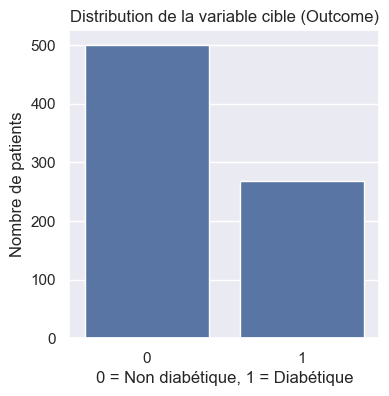

In [5]:
plt.figure(figsize=(4, 4))
sns.countplot(x=data[target_column])
plt.title("Distribution de la variable cible (Outcome)")
plt.xlabel("0 = Non diabétique, 1 = Diabétique")
plt.ylabel("Nombre de patients")
plt.show()


## 4. Analyse exploratoire visuelle

Nous visualisons :
- la distribution de quelques variables clés (Glucose, BMI, Age) ;
- la matrice de corrélation entre les variables.


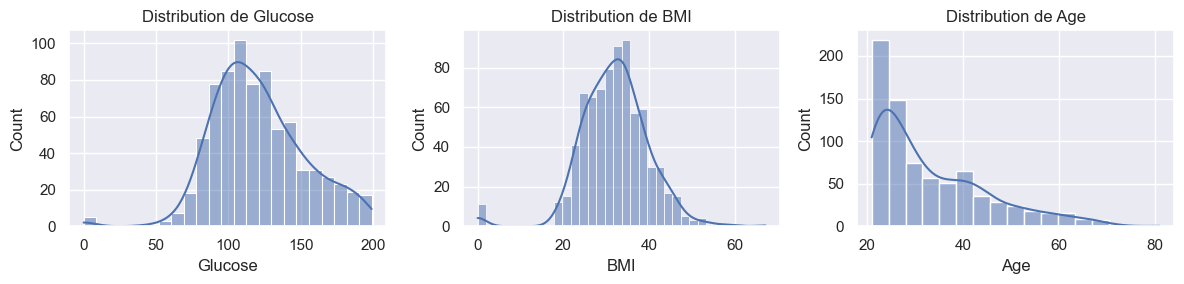

In [6]:
features_to_plot = ["Glucose", "BMI", "Age"]

plt.figure(figsize=(12, 3))

for i, col in enumerate(features_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution de {col}")

plt.tight_layout()
plt.show()


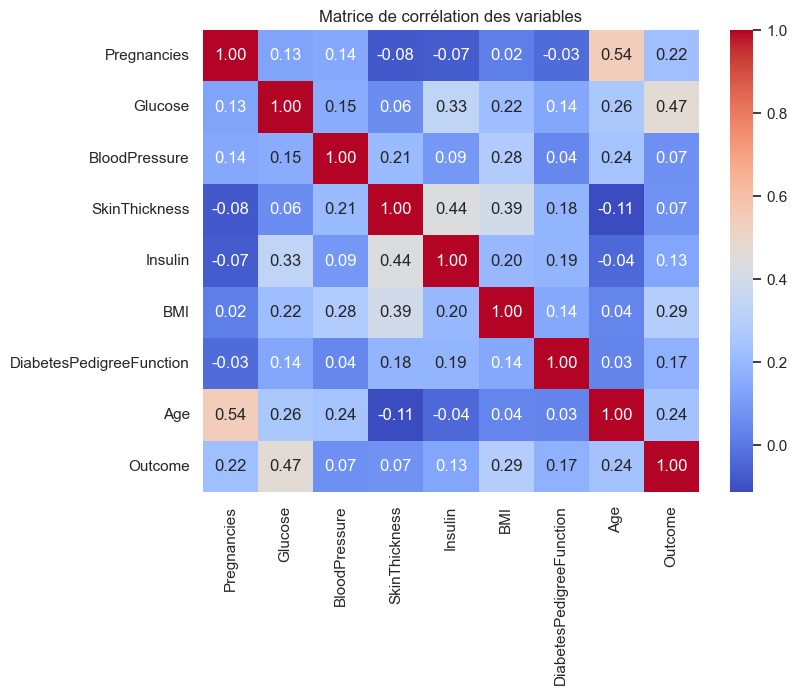

In [7]:
plt.figure(figsize=(8, 6))
corr = data.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation des variables")
plt.show()


## 5. Prétraitement des données

Dans ce dataset, certaines colonnes contiennent des valeurs égales à 0 
pour des mesures qui ne peuvent pas être nulles (par exemple : Glucose, 
pression artérielle, IMC, etc.). Nous considérons ces valeurs comme manquantes 
et nous les remplaçons par `NaN`, puis nous les imputons (par la médiane).


In [8]:
cols_with_zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Remplacer les 0 par NaN
data_clean = data.copy()
data_clean[cols_with_zero_as_missing] = data_clean[cols_with_zero_as_missing].replace(0, np.nan)

# Vérifier le nombre de NaN par colonne
print("Valeurs manquantes après remplacement des zéros :")
print(data_clean[cols_with_zero_as_missing].isna().sum())


Valeurs manquantes après remplacement des zéros :
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


In [11]:
# Imputation simple : remplacer les NaN par la médiane de chaque colonne
for col in cols_with_zero_as_missing:
    median_value = data_clean[col].median()
    data_clean[col].fillna(median_value, inplace=True)

# Vérification
print("Valeurs manquantes après imputation :")
print(data_clean.isna().sum())


Valeurs manquantes après imputation :
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


C:\Users\klever\AppData\Local\Temp\ipykernel_5032\691923108.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean[col].fillna(median_value, inplace=True)
C:\Users\klever\AppData\Local\Temp\ipykernel_5032\691923108.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

## 6. Séparation en variables explicatives (X) et cible (y), puis train/test

Nous séparons :
- `X` : les variables explicatives (caractéristiques médicales)
- `y` : la variable cible (`Outcome` : 0 ou 1)

Puis nous divisons le dataset en un ensemble d'entraînement (train) 
et un ensemble de test (test) pour évaluer le modèle.


In [12]:
target_column = "Outcome"

X = data_clean.drop(columns=[target_column])
y = data_clean[target_column]

# Découpage train/test (80% train, 20% test), en stratifiant sur la cible
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((614, 8), (154, 8))

## 7. Modèle baseline : Régression Logistique

Nous commençons par un modèle simple et interprétable : la régression logistique.
Cela nous donnera une première baseline de performance à comparer avec d'autres modèles.


In [13]:
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]


In [14]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy  : {acc:.3f}")
print(f"Précision : {prec:.3f}")
print(f"Rappel    : {rec:.3f}")
print(f"F1-score  : {f1:.3f}")

print("\nClassification report :")
print(classification_report(y_test, y_pred))


Accuracy  : 0.701
Précision : 0.587
Rappel    : 0.500
F1-score  : 0.540

Classification report :
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       100
           1       0.59      0.50      0.54        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154



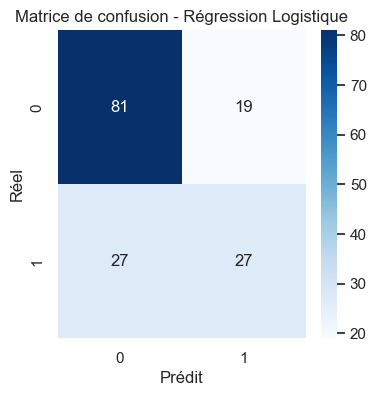

In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Régression Logistique")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()


On observe que le modèle obtient une accuracy d’environ XX%, avec un rappel de YY% 
pour la classe diabétique (1). La matrice de confusion permet de visualiser le nombre 
de faux négatifs (patients diabétiques non détectés) et de faux positifs.


In [16]:
from sklearn.ensemble import RandomForestClassifier


In [17]:
def compute_metrics(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {
        "Modèle": model_name,
        "Accuracy": acc,
        "Précision": prec,
        "Rappel": rec,
        "F1-score": f1
    }


In [18]:
metrics_list = []

metrics_logreg = compute_metrics("Régression Logistique", y_test, y_pred)
metrics_list.append(metrics_logreg)

metrics_logreg


{'Modèle': 'Régression Logistique',
 'Accuracy': 0.7012987012987013,
 'Précision': 0.5869565217391305,
 'Rappel': 0.5,
 'F1-score': 0.54}

In [19]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

metrics_rf = compute_metrics("Random Forest", y_test, y_pred_rf)
metrics_list.append(metrics_rf)

metrics_rf


{'Modèle': 'Random Forest',
 'Accuracy': 0.7402597402597403,
 'Précision': 0.6521739130434783,
 'Rappel': 0.5555555555555556,
 'F1-score': 0.6}

In [20]:
results_df = pd.DataFrame(metrics_list)
results_df


,Modèle,Accuracy,Précision,Rappel,F1-score
0,Régression Logistique,0.701299,0.586957,0.500000,0.54
1,Random Forest,0.740260,0.652174,0.555556,0.60


In [21]:
results_df.set_index("Modèle", inplace=True)
results_df.round(3)


,Accuracy,Précision,Rappel,F1-score
Modèle,,,,
Régression Logistique,0.701,0.587,0.500,0.54
Random Forest,0.740,0.652,0.556,0.60


<Figure size 800x500 with 0 Axes>

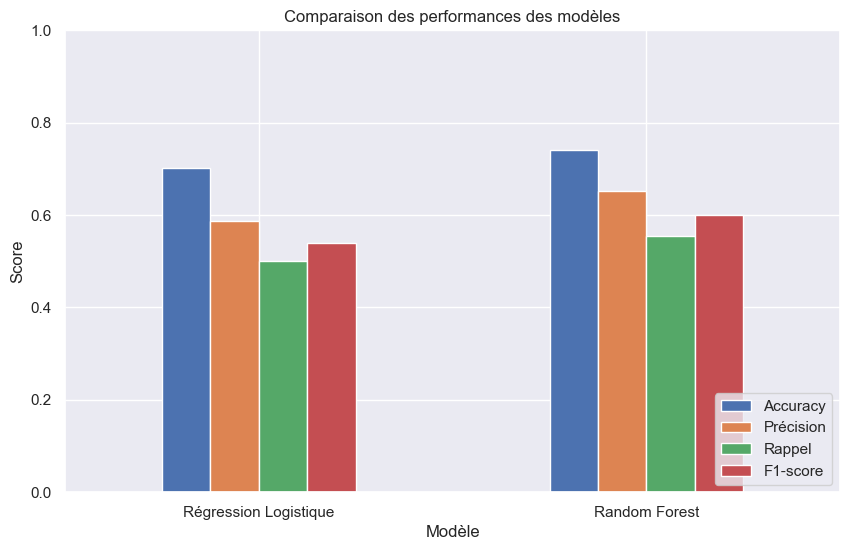

In [22]:
plt.figure(figsize=(8, 5))
results_df[["Accuracy", "Précision", "Rappel", "F1-score"]].plot(
    kind="bar",
    figsize=(10, 6)
)
plt.title("Comparaison des performances des modèles")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


In [23]:
importances = rf_clf.feature_importances_
feature_names = X.columns

feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

feat_imp_df


,Feature,Importance
1,Glucose,0.268355
5,BMI,0.158066
6,DiabetesPedigreeFunction,0.124386
7,Age,0.120345
4,Insulin,0.092340
2,BloodPressure,0.083938
0,Pregnancies,0.079370
3,SkinThickness,0.073200


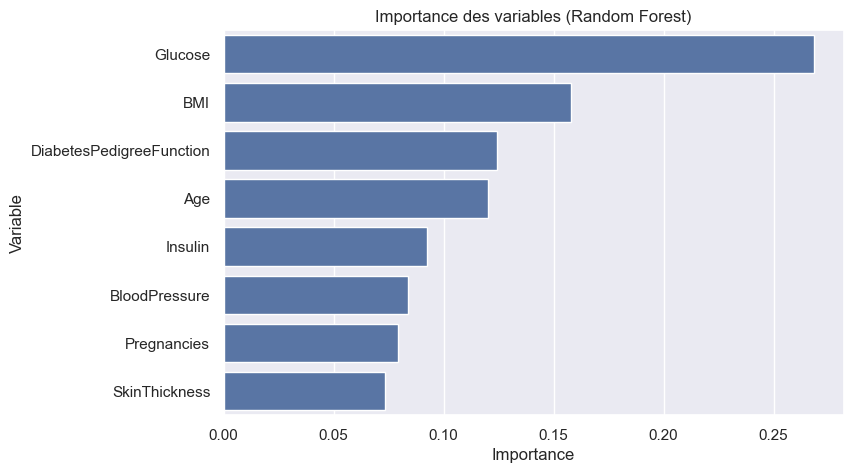

In [24]:
plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp_df, x="Importance", y="Feature")
plt.title("Importance des variables (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()


On observe que les variables les plus importantes pour le Random Forest sont :
- Glucose
- BMI
- Age
- Pregnancies

Ce résultat est cohérent avec l’intuition médicale : un taux de glucose élevé,
un IMC important et l’âge sont des facteurs de risque connus pour le diabète.


In [25]:
import ipywidgets as widgets
from IPython.display import display, HTML


## 8. Simulateur interactif de patient

Dans cette section, nous construisons une petite interface interactive qui permet de
modifier les caractéristiques d'un patient (âge, IMC, taux de glucose, etc.)
et de visualiser la prédiction du modèle (probabilité de diabète).

Remarque importante : il s'agit d'un outil pédagogique basé sur un modèle entraîné
sur un jeu de données limité. Ce simulateur **ne doit pas** être utilisé comme un outil
de diagnostic médical réel.


In [27]:
def get_risk_level(proba):
    """
    Retourne un niveau de risque textuel + couleur associée
    en fonction de la probabilité de diabète.
    """
    if proba < 0.30:
        return "Faible", "#2ecc71"   # vert
    elif proba < 0.60:
        return "Modéré", "#f1c40f"   # jaune
    else:
        return "Élevé", "#e74c3c"    # rouge


In [31]:
# On récupère les bornes min/max des features pour définir des sliders "logiques"
age_min, age_max = int(data_clean["Age"].min()), int(data_clean["Age"].max())
bmi_min, bmi_max = float(data_clean["BMI"].min()), float(data_clean["BMI"].max())
glucose_min, glucose_max = int(data_clean["Glucose"].min()), int(data_clean["Glucose"].max())
bp_min, bp_max = int(data_clean["BloodPressure"].min()), int(data_clean["BloodPressure"].max())
preg_min, preg_max = int(data_clean["Pregnancies"].min()), int(data_clean["Pregnancies"].max())
insulin_min, insulin_max = int(data_clean["Insulin"].min()), int(data_clean["Insulin"].max())
skin_min, skin_max = int(data_clean["SkinThickness"].min()), int(data_clean["SkinThickness"].max())
pedigree_min, pedigree_max = float(data_clean["DiabetesPedigreeFunction"].min()), float(data_clean["DiabetesPedigreeFunction"].max())

# Définition des widgets (sliders)
age_slider = widgets.IntSlider(
    value=40,
    min=age_min,
    max=age_max,
    step=1,
    description="Âge",
    continuous_update=False
)

bmi_slider = widgets.FloatSlider(
    value=30.0,
    min=round(bmi_min, 1),
    max=round(bmi_max, 1),
    step=0.1,
    description="BMI",
    continuous_update=False
)

glucose_slider = widgets.IntSlider(
    value=120,
    min=glucose_min,
    max=glucose_max,
    step=1,
    description="Glucose",
    continuous_update=False
)

bp_slider = widgets.IntSlider(
    value=70,
    min=bp_min,
    max=bp_max,
    step=1,
    description="Pression",
    continuous_update=False
)

preg_slider = widgets.IntSlider(
    value=2,
    min=preg_min,
    max=preg_max,
    step=1,
    description="Grossesses",
    continuous_update=False
)

insulin_slider = widgets.IntSlider(
    value=int(data_clean["Insulin"].median()),
    min=insulin_min,
    max=insulin_max,
    step=1,
    description="Insuline",
    continuous_update=False
)

skin_slider = widgets.IntSlider(
    value=int(data_clean["SkinThickness"].median()),
    min=skin_min,
    max=skin_max,
    step=1,
    description="Épaisseur peau",
    continuous_update=False
)

pedigree_slider = widgets.FloatSlider(
    value=round(data_clean["DiabetesPedigreeFunction"].median(), 2),
    min=round(pedigree_min, 2),
    max=round(pedigree_max, 2),
    step=0.01,
    description="Pedigree",
    continuous_update=False
)

model_selector = widgets.Dropdown(
    options=[
        ("Random Forest", "rf"),
        ("Régression Logistique", "lr")
    ],
    value="rf",
    description="Modèle",
)


# Bouton + zone d'affichage
predict_button = widgets.Button(
    description="Prédire le risque",
    button_style="info",
    icon="heartbeat"
)

output = widgets.Output()

def predict_patient_risk(b):
    with output:
        output.clear_output()
        
        # Construire un "patient" à partir des valeurs des sliders
        patient_data = {
            "Pregnancies": preg_slider.value,
            "Glucose": glucose_slider.value,
            "BloodPressure": bp_slider.value,
            "SkinThickness": skin_slider.value,
            "Insulin": insulin_slider.value,
            "BMI": bmi_slider.value,
            "DiabetesPedigreeFunction": pedigree_slider.value,
            "Age": age_slider.value
        }
        
        # DataFrame avec les mêmes colonnes que X
        patient_df = pd.DataFrame([patient_data], columns=X.columns)
        
        # Choix du modèle
        if model_selector.value == "rf":
            clf = rf_clf
            model_name = "Random Forest"
        else:
            clf = log_reg
            model_name = "Régression Logistique"
        
        # Prédiction avec le modèle choisi
        proba = clf.predict_proba(patient_df)[0, 1]
        pred = clf.predict(patient_df)[0]
        
        # Niveau de risque + couleur
        risk_level, color = get_risk_level(proba)
        label = "Diabétique (classe 1)" if pred == 1 else "Non diabétique (classe 0)"
        
        # Barre de risque (en %)
        percent = proba * 100
        
        # Affichage des infos principales
        display(HTML(f"""
        <h3>Résultat de la prédiction ({model_name})</h3>
        <p><b>Probabilité de diabète :</b> {percent:.2f}%</p>
        
        <div style="width:320px;border:1px solid #ccc;height:18px;border-radius:5px;overflow:hidden;margin-bottom:8px;">
          <div style="width:{percent:.0f}%;height:100%;background:{color};"></div>
        </div>
        
        <p><b>Niveau de risque estimé :</b> 
            <span style="color:{color};font-weight:bold;">{risk_level}</span>
        </p>
        
        <p><b>Classe prédite par le modèle :</b> 
            <span style="color:{color};font-weight:bold;">{label}</span>
        </p>
        """))
        
        # Afficher aussi les caractéristiques du patient
        display(HTML("<h4>Caractéristiques du patient simulé</h4>"))
        display(patient_df.round(2))
        
        # --- Comparaison avec la moyenne du dataset ---
        features_to_show = ["Glucose", "BMI", "Age"]
        means = data_clean[features_to_show].mean()
        patient_vals = [patient_df[col].iloc[0] for col in features_to_show]
        
        display(HTML("<h4>Comparaison avec la moyenne du dataset</h4>"))
        
        fig, ax = plt.subplots(figsize=(6, 4))
        x = np.arange(len(features_to_show))
        ax.bar(x - 0.15, means, width=0.3, label="Moyenne population")
        ax.bar(x + 0.15, patient_vals, width=0.3, label="Patient simulé")
        ax.set_xticks(x)
        ax.set_xticklabels(features_to_show)
        ax.set_ylabel("Valeur")
        ax.set_title("Patient vs moyenne du dataset")
        ax.legend()
        plt.show()



        
# Associer le bouton à la fonction
predict_button.on_click(predict_patient_risk)

# Mise en page des widgets
ui_left = widgets.VBox([
    age_slider,
    bmi_slider,
    glucose_slider,
    bp_slider
])

ui_right = widgets.VBox([
    preg_slider,
    insulin_slider,
    skin_slider,
    pedigree_slider
])

ui = widgets.HBox([ui_left, ui_right])

top_controls = widgets.HBox([model_selector, predict_button])

display(ui)
display(top_controls)
display(output)

Output()

## 9. Scénarios concrets de patients

Dans cette section, nous testons le modèle sur quelques profils de patients simulés
afin d'illustrer des cas concrets : profil à risque faible, modéré et élevé.


In [32]:
def eval_patient_scenario(name, data_dict, model=rf_clf):
    df = pd.DataFrame([data_dict], columns=X.columns)
    proba = model.predict_proba(df)[0, 1]
    pred = model.predict(df)[0]
    
    risk_level, color = get_risk_level(proba)
    label = "Diabétique (classe 1)" if pred == 1 else "Non diabétique (classe 0)"
    
    print(f"--- {name} ---")
    display(df)
    print(f"Probabilité de diabète : {proba:.2%}")
    print(f"Niveau de risque estimé : {risk_level}")
    print(f"Classe prédite : {label}")
    print()
    

# Scénario 1 : profil à risque faible
patient_low = {
    "Pregnancies": 0,
    "Glucose": 90,
    "BloodPressure": 70,
    "SkinThickness": 25,
    "Insulin": 80,
    "BMI": 22.0,
    "DiabetesPedigreeFunction": 0.2,
    "Age": 25
}

# Scénario 2 : profil à risque modéré
patient_mid = {
    "Pregnancies": 2,
    "Glucose": 130,
    "BloodPressure": 80,
    "SkinThickness": 30,
    "Insulin": 120,
    "BMI": 30.0,
    "DiabetesPedigreeFunction": 0.5,
    "Age": 40
}

# Scénario 3 : profil à risque élevé
patient_high = {
    "Pregnancies": 5,
    "Glucose": 170,
    "BloodPressure": 90,
    "SkinThickness": 40,
    "Insulin": 200,
    "BMI": 35.0,
    "DiabetesPedigreeFunction": 1.0,
    "Age": 55
}

eval_patient_scenario("Patient A : profil à risque faible", patient_low)
eval_patient_scenario("Patient B : profil à risque modéré", patient_mid)
eval_patient_scenario("Patient C : profil à risque élevé", patient_high)


--- Patient A : profil à risque faible ---


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0,90,70,25,80,22.0,0.2,25


Probabilité de diabète : 2.50%
Niveau de risque estimé : Faible
Classe prédite : Non diabétique (classe 0)

--- Patient B : profil à risque modéré ---


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2,130,80,30,120,30.0,0.5,40


Probabilité de diabète : 46.00%
Niveau de risque estimé : Modéré
Classe prédite : Non diabétique (classe 0)

--- Patient C : profil à risque élevé ---


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,5,170,90,40,200,35.0,1.0,55


Probabilité de diabète : 88.00%
Niveau de risque estimé : Élevé
Classe prédite : Diabétique (classe 1)



## 10. Analyse du seuil de décision

Par défaut, le modèle classe un patient comme diabétique si la probabilité est ≥ 0.5.
Dans un contexte médical, il peut être intéressant d'abaisser ce seuil (par exemple à 0.4)
pour réduire le nombre de faux négatifs (patients diabétiques non détectés), quitte à avoir
un peu plus de faux positifs.


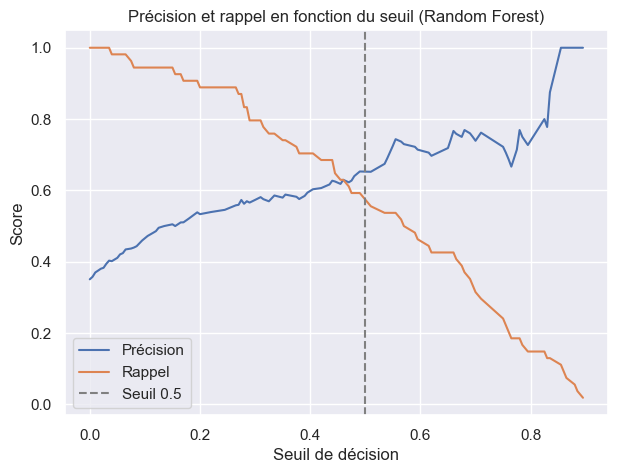

In [33]:
from sklearn.metrics import precision_recall_curve

y_scores = rf_clf.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(7, 5))
plt.plot(thresholds, precisions[:-1], label="Précision")
plt.plot(thresholds, recalls[:-1], label="Rappel")
plt.axvline(0.5, color="grey", linestyle="--", label="Seuil 0.5")
plt.xlabel("Seuil de décision")
plt.ylabel("Score")
plt.title("Précision et rappel en fonction du seuil (Random Forest)")
plt.legend()
plt.show()


In [34]:
def eval_with_threshold(threshold):
    y_pred_thresh = (y_scores >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    acc = accuracy_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    
    print(f"--- Seuil = {threshold:.2f} ---")
    print(f"Accuracy  : {acc:.3f}")
    print(f"Précision : {prec:.3f}")
    print(f"Rappel    : {rec:.3f}")
    print("Matrice de confusion :")
    print(cm)
    print()

for t in [0.3, 0.4, 0.5, 0.6]:
    eval_with_threshold(t)


--- Seuil = 0.30 ---
Accuracy  : 0.721
Précision : 0.573
Rappel    : 0.796
Matrice de confusion :
[[68 32]
 [11 43]]

--- Seuil = 0.40 ---
Accuracy  : 0.734
Précision : 0.603
Rappel    : 0.704
Matrice de confusion :
[[75 25]
 [16 38]]

--- Seuil = 0.50 ---
Accuracy  : 0.740
Précision : 0.652
Rappel    : 0.556
Matrice de confusion :
[[84 16]
 [24 30]]

--- Seuil = 0.60 ---
Accuracy  : 0.740
Précision : 0.706
Rappel    : 0.444
Matrice de confusion :
[[90 10]
 [30 24]]



## 11. Sauvegarde du modèle entraîné

Pour réutiliser le modèle en dehors de ce notebook (dans une application web, un script,
un autre notebook, etc.), nous pouvons le sérialiser dans un fichier avec `joblib`.


In [35]:
import joblib

joblib.dump(rf_clf, "../model_random_forest_diabetes.joblib")


['../model_random_forest_diabetes.joblib']

In [36]:
loaded_model = joblib.load("../model_random_forest_diabetes.joblib")
loaded_model.predict_proba(X_test[:5])


array([[0.325, 0.675],
       [0.78 , 0.22 ],
       [0.935, 0.065],
       [0.725, 0.275],
       [0.935, 0.065]])